In [1]:
from independence_weights import *
from simulate_data import *

In [2]:
import numpy as np
import torch
import pandas as pd
from scipy.stats import chi2


def simulate_data(seed=1, nobs=1000, MX1=-0.5, MX2=1, MX3=0.3, A_effect=True):
    np.random.seed(seed)

    # Generate covariates and dose
    X1 = np.random.normal(loc=MX1, scale=1, size=nobs)
    X2 = np.random.normal(loc=MX2, scale=1, size=nobs)
    X3 = np.random.normal(loc=0, scale=1, size=nobs)
    X4 = np.random.normal(loc=MX2, scale=1, size=nobs)
    X5 = np.random.binomial(n=1, p=MX3, size=nobs)

    Z1 = np.exp(X1 / 2)
    Z2 = (X2 / (1 + np.exp(X1))) + 10
    Z3 = (X1 * X3 / 25) + 0.6
    Z4 = (X4 - MX2) ** 2
    Z5 = X5

    muA = 5 * np.abs(X1) + 6 * np.abs(X2) + 3 * np.abs(X5) + np.abs(X4)

    A = (chi2.rvs(df=3, loc=0, scale=1, size=nobs) + muA)

    def true_density_A_X(A, X):
        muA_true = 5 * np.abs(X[:, 0]) + 6 * np.abs(X[:, 1]) + \
            3 * np.abs(X[:, 4]) + np.abs(X[:, 3])
        return chi2.pdf(A, df=3, loc=0, scale=1, nc=muA_true)

    if A_effect:
        Cnum = 1161.25
        Y = -0.15 * A ** 2 + A * (X1 ** 2 + X2 ** 2) - 15 + (X1 + 3) ** 2 + 2 * (
            X2 - 25) ** 2 + X3 - Cnum + np.random.normal(scale=1, size=nobs)
        Y = Y / 50
        
        truth = -0.15 * A ** 2 + A * 0.065 - 15
        truth = truth / 50
    else:
        
        Y = X1 + X1 ** 2 + X2 + X2 ** 2 + X1 * X2 + \
            X5 + np.random.normal(scale=1, size=nobs)
        truth = 5.05
    

    datz = pd.DataFrame({
        'Y': Y,
        'A': A,
        'Z1': Z1,
        'Z2': Z2,
        'Z3': Z3,
        'Z4': Z4,
        'Z5': Z5,
        'truth': truth
    })

    datx = pd.DataFrame({
        'X1': X1,
        'X2': X2,
        'X3': X3,
        'X4': X4,
        'X5': X5
    })

    return {
        'data': datz,
        'true_adrf': truth,
        'original_covariates': datx,
        'true_density_A_X': true_density_A_X
    }

In [4]:
def off_policy_evaulation_DCOWs(**params): 
#using DCOWs to estimate the value function
    
    y_out = params['y']; x = params['x']; h = params['h']; n = params['n']; t_lo = params['t_lo'];  t_hi = params['t_hi']
    kernel = params['kernel_func'];kernel_int =  params['kernel_int_func']
    if ('y_samp' in params.keys()):
        y_out = params['y_samp']
    if ('T_samp' in params.keys()): 
        T = params['T_samp']
    else: 
        T = params['T']
    if ('x_samp' in params.keys()):
        x = params['x_samp']

    weights=independence_weights(T, x)['weights']
    
    
    value_function_estimation = 0
    tau = params['tau']
    clip_tau = np.clip(tau, t_lo, t_hi)
    
    for i in np.arange(n): 
        
        if (abs(clip_tau[i] - t_lo) <= h):
            alpha = kernel_int((t_lo-clip_tau[i])/h, 1)
        elif (abs(clip_tau[i] - t_hi) <= h):
            alpha = kernel_int(-1,  (t_hi - clip_tau[i])/h )
        else:
            alpha = 1
       
        value_function_estimation += kernel( (clip_tau[i] - T[i])/h )*weights[i] * y_out[i]/ (n*h)
    
    return value_function_estimation



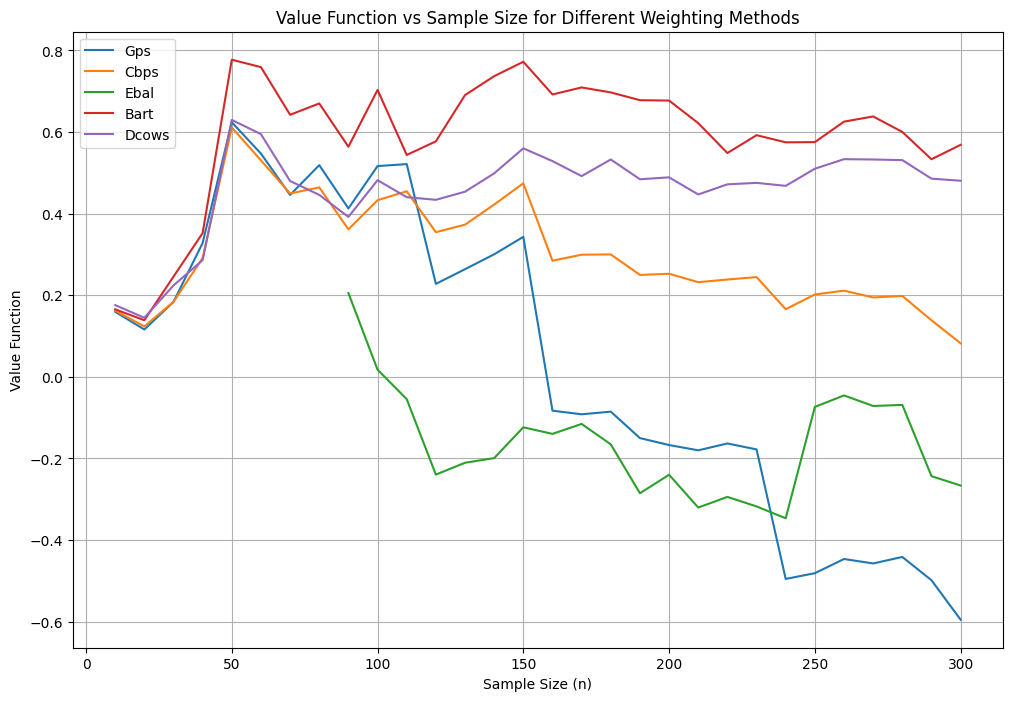

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from independence_weights import independence_weights

def kernel_func(u):
    return np.exp(-u**2 / 2) / np.sqrt(2 * np.pi)

def kernel_int_func(a, b):
    result, _ = quad(kernel_func, a, b)
    return result

def calculate_value_function(y, T, X, weights, h):
    n = len(y)
    value_function_estimation = 0
    for i in range(n):
        value_function_estimation += kernel_func((X[i] - T[i]) / h) * weights[i] * y[i] / (np.sum(kernel_func((X - T) / h) * weights))
    return value_function_estimation

def calculate_confidence_intervals(values, confidence=0.99):
    mean_val = np.mean(values)
    sem = np.std(values) / np.sqrt(len(values))
    h = sem * norm.ppf((1 + confidence) / 2)
    return mean_val, mean_val - h, mean_val + h

def off_policy_evaluation_DCOWs(y, T, X, weights, h, t_lo, t_hi, kernel_func, kernel_int_func):
    n = len(y)
    tau = X
    value_function_estimation = 0
    for i in range(n): 
        if abs(tau[i] - t_lo) <= h:
            alpha = kernel_int_func((t_lo - tau[i]) / h, 1)
        elif abs(tau[i] - t_hi) <= h:
            alpha = kernel_int_func(-1, (t_hi - tau[i]) / h)
        else:
            alpha = 1
        value_function_estimation += kernel_func((tau[i] - T[i]) / h) * weights[i] * y[i] /( np.sum(kernel_func((tau - T) / h) * weights))
    return value_function_estimation

# Initialize arrays
sample_sizes = np.arange(10, 301, 10)
methods = ['gps', 'cbps', 'ebal', 'bart', 'dcows']
final_results = {method: {'mean': [], 'ci_lower': [], 'ci_upper': []} for method in methods}
h = 0.01


# Read data
weights_results = pd.read_csv('weights_results.csv')
simulated_data = pd.read_csv('simulated_data.csv')

for n in sample_sizes:
    values = {method: [] for method in methods}
    
    for rep in range(1, 101):  # Assuming 100 batches as per the R script
        batch_data = simulated_data[(simulated_data['nobs'] == n) & (simulated_data['batch'] == rep)]
        weights_n = weights_results[(weights_results['nobs'] == n) & (weights_results['batch'] == rep)]
       

        if not batch_data.empty:
            y = batch_data['Y'].values
            T = batch_data['A'].values
            t_lo = T.min()
            t_hi = T.max()
            Xs = batch_data[['Z1', 'Z2', 'Z3', 'Z4', 'Z5']].values
            X = np.zeros(len(y))  # Assuming X needs to be computed or is zero
            
            for method in methods[:-1]:  # Exclude 'dcows' for separate processing
                weights = weights_n[f'{method}_weights'].values
                value = calculate_value_function(y, T, X, weights, h)
                values[method].append(value)
            
            # Special case for DCOWs
            weights = independence_weights(T, Xs)['weights'] 
            dcows_value = off_policy_evaluation_DCOWs(y, T, X, weights, h, t_lo, t_hi, kernel_func, kernel_int_func)
            values['dcows'].append(dcows_value)

    # Aggregate results
    for method in methods:
        mean_val, ci_lower, ci_upper = calculate_confidence_intervals(values[method])
        final_results[method]['mean'].append(mean_val)
        final_results[method]['ci_lower'].append(ci_lower)
        final_results[method]['ci_upper'].append(ci_upper)

# Plotting the results as line plots with confidence intervals
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(sample_sizes, final_results[method]['mean'], label=method.capitalize())
    

plt.xlabel('Sample Size (n)')
plt.ylabel('Value Function')
plt.title('Value Function vs Sample Size for Different Weighting Methods')
plt.legend()
plt.grid(True)
plt.show()


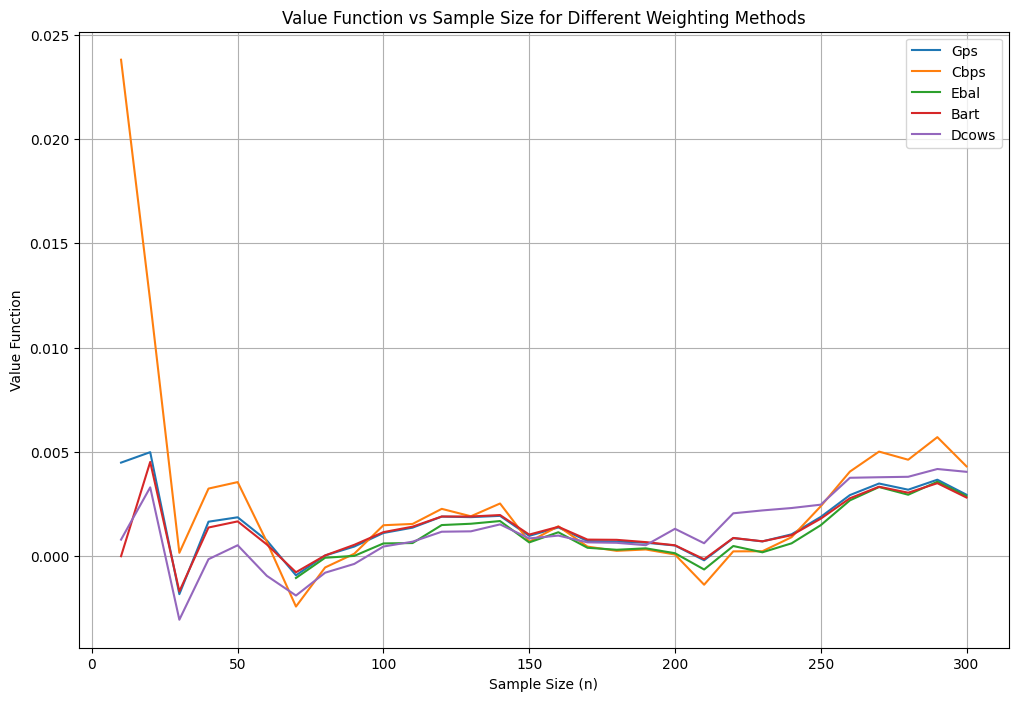

In [17]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from independence_weights import independence_weights

def kernel_func(u):
    return np.exp(-u**2 / 2) / np.sqrt(2 * np.pi)

def kernel_int_func(a, b):
    result, _ = quad(kernel_func, a, b)
    return result

def calculate_value_function(y, T, X, weights, h):
    n = len(y)
    value_function_estimation = 0
    for i in range(n):
        value_function_estimation += kernel_func((X[i] - T[i]) / h) *  y[i] / (np.sum(kernel_func((X - T) / h) * weights))
    return value_function_estimation

def calculate_confidence_intervals(values, confidence=0.99):
    mean_val = np.mean(values)
    sem = np.std(values) / np.sqrt(len(values))
    h = sem * norm.ppf((1 + confidence) / 2)
    return mean_val, mean_val - h, mean_val + h

def off_policy_evaluation_DCOWs(y, T, X, weights, h, t_lo, t_hi, kernel_func, kernel_int_func):
    n = len(y)
    tau = X
    value_function_estimation = 0
    for i in range(n): 
        if abs(tau[i] - t_lo) <= h:
            alpha = kernel_int_func((t_lo - tau[i]) / h, 1)
        elif abs(tau[i] - t_hi) <= h:
            alpha = kernel_int_func(-1, (t_hi - tau[i]) / h)
        else:
            alpha = 1
        value_function_estimation += kernel_func((tau[i] - T[i]) / h) * weights[i] * y[i] /( np.sum(kernel_func((tau - T) / h) * weights))
    return value_function_estimation

# Initialize arrays
sample_sizes = np.arange(10, 301, 10)
methods = ['gps', 'cbps', 'ebal', 'bart', 'dcows']
final_results = {method: {'mean': [], 'ci_lower': [], 'ci_upper': []} for method in methods}
h = 0.01


# Read data
weights_results = pd.read_csv('weights_results1.csv')
simulated_data = pd.read_csv('simulated_data1.csv')

for n in sample_sizes:
    values = {method: [] for method in methods}
    
    for rep in range(1, 101):  # Assuming 100 batches as per the R script
        batch_data = simulated_data[(simulated_data['nobs'] == n) & (simulated_data['batch'] == rep)]
        weights_n = weights_results[(weights_results['nobs'] == n) & (weights_results['batch'] == rep)]

        if not batch_data.empty:
            y = batch_data['Y'].values
            T = batch_data['A'].values
            t_lo = T.min()
            t_hi = T.max()
            Xs = batch_data[['X1', 'X2', 'X3', 'X4', 'X5']].values
            X =  np.sum(Xs, axis=1)/10
            
            for method in methods[:-1]:  # Exclude 'dcows' for separate processing
                weights = weights_n[f'{method}_weights'].values
                value = calculate_value_function(y, T, X, weights, h)
                values[method].append(value)
            
            # Special case for DCOWs
            weights = independence_weights(T, Xs)['weights'] 
            dcows_value = off_policy_evaluation_DCOWs(y, T, X, weights, h, t_lo, t_hi, kernel_func, kernel_int_func)
            values['dcows'].append(dcows_value)

    # Aggregate results
    for method in methods:
        mean_val, ci_lower, ci_upper = calculate_confidence_intervals(values[method])
        final_results[method]['mean'].append(mean_val)
        final_results[method]['ci_lower'].append(ci_lower)
        final_results[method]['ci_upper'].append(ci_upper)

# Plotting the results as line plots with confidence intervals
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(sample_sizes, final_results[method]['mean'], label=method.capitalize())
    

plt.xlabel('Sample Size (n)')
plt.ylabel('Value Function')
plt.title('Value Function vs Sample Size for Different Weighting Methods')
plt.legend()
plt.grid(True)
plt.show()